In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import keras

Using TensorFlow backend.


In [3]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

#train = np.loadtxt('/media/ivan/778B482205074FE31/data/mnist/train.csv', delimiter=',', skiprows=1)
#test = np.loadtxt('/media/ivan/778B482205074FE31/data/mnist/test.csv', delimiter=',', skiprows=1)

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [5]:
#Train
#1
chunks =  [train_img[:, :14, :14], train_img[:, 14:, :14], train_img[:, :14, 14:], train_img[:, 14:, 14:]]

In [6]:
#2
chunks_final = np.zeros((len(train_img), 1))

for i in range(len(chunks)):
    chunks_sobel_x = np.zeros_like(chunks[i] )
    chunks_sobel_y = np.zeros_like(chunks[i] )
    for m in range(len(chunks[i])):
        chunks_sobel_x[m] = cv2.Sobel(chunks[i][m], cv2.CV_64F, dx=1, dy=0, ksize=3)
        chunks_sobel_y[m] = cv2.Sobel(chunks[i][m], cv2.CV_64F, dx=0, dy=1, ksize=3)
    chunks_g, chunks_theta = cv2.cartToPolar(chunks_sobel_x, chunks_sobel_y)      #3
    
    chunks_hist = np.zeros((len(chunks[i]), 16))   #4
    for x in range(len(chunks[i])):
        hist, borders = np.histogram(chunks_theta[x],
                                     bins=16,
                                     range=(0., 2. * np.pi),
                                     weights=chunks_g[x])
        chunks_hist[x] = hist
    chunks_final = np.hstack((chunks_final, chunks_hist))

chunks_final = chunks_final[:, 1:] #5

In [7]:
#Test
#1
chunks_tst =  [test_img[:, :14, :14], test_img[:, 14:, :14], test_img[:, :14, 14:], test_img[:, 14:, 14:]]

In [8]:
#2
chunks_final_tst = np.zeros((len(test_img), 1))

for i in range(len(chunks_tst)):
    chunks_sobel_x = np.zeros_like(chunks_tst[i] )
    chunks_sobel_y = np.zeros_like(chunks_tst[i] )
    for m in range(len(chunks_tst[i])):
        chunks_sobel_x[m] = cv2.Sobel(chunks_tst[i][m], cv2.CV_64F, dx=1, dy=0, ksize=3)
        chunks_sobel_y[m] = cv2.Sobel(chunks_tst[i][m], cv2.CV_64F, dx=0, dy=1, ksize=3)
    chunks_g, chunks_theta = cv2.cartToPolar(chunks_sobel_x, chunks_sobel_y)      #3
    
    chunks_hist = np.zeros((len(chunks_tst[i]), 16))
    for x in range(len(chunks_tst[i])):
        hist, borders = np.histogram(chunks_theta[x],
                                     bins=16,
                                     range=(0., 2. * np.pi),
                                     weights=chunks_g[x])
        chunks_hist[x] = hist
    chunks_final_tst = np.hstack((chunks_final_tst, chunks_hist))

chunks_final_tst = chunks_final_tst[:, 1:]

In [9]:
# нормализация методом из opencv
train_zero = np.zeros((42000, 64))
train_norm = cv2.normalize(chunks_final, train_zero)
test_norm = cv2.normalize(chunks_final_tst, train_zero)

## Разбиваем выборку на обучение и валидацию

In [10]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_norm, test_size=0.2, random_state=42)

## Собираем полносвязную сеть для обучения

In [23]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(256, input_dim=x_train.shape[1], activation='relu'
#                            ,kernel_initializer='random_uniform'
                            )) # 
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(256, input_dim=x_train.shape[1], activation='relu'
#                            ,kernel_initializer='random_uniform'
                            )) # 
model.add(keras.layers.Dropout(0.3))

#model.add(keras.layers.Dense(256, input_dim=x_train.shape[1], activation='relu')) # 
#model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Dense(10, activation='softmax')) # softmax сколько классов == столько выходных нейронов

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Выводим информацию о модели

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 85,002
Trainable params: 85,002
Non-trainable params: 0
_________________________________________________________________


## One hot encoding разметки

In [25]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

In [26]:
print( y_train.shape, y_train_labels.shape, train_norm.shape)

(33600,) (33600, 10) (42000, 64)


## Запускаем обучение

In [27]:
model.fit(x_train, y_train_labels, batch_size=128, epochs=250) #, epochs=250

Epoch 1/250
33600/33600 [==============================] - 1s - loss: 2.2542 - acc: 0.1607     
Epoch 2/250
33600/33600 [==============================] - 1s - loss: 1.7296 - acc: 0.3805     
Epoch 3/250
33600/33600 [==============================] - 1s - loss: 1.2719 - acc: 0.5716     
Epoch 4/250
33600/33600 [==============================] - 1s - loss: 1.0071 - acc: 0.6650     
Epoch 5/250
33600/33600 [==============================] - 1s - loss: 0.8320 - acc: 0.7238     
Epoch 6/250
33600/33600 [==============================] - 1s - loss: 0.7139 - acc: 0.7633     
Epoch 7/250
33600/33600 [==============================] - 1s - loss: 0.6360 - acc: 0.7932     
Epoch 8/250
33600/33600 [==============================] - 1s - loss: 0.5750 - acc: 0.8118     
Epoch 9/250
33600/33600 [==============================] - 1s - loss: 0.5300 - acc: 0.8287     
Epoch 10/250
33600/33600 [==============================] - 1s - loss: 0.4914 - acc: 0.8399     
Epoch 11/250
33600/33600 [=============

33600/33600 [==============================] - 1s - loss: 0.1660 - acc: 0.9459     
Epoch 86/250
33600/33600 [==============================] - 1s - loss: 0.1697 - acc: 0.9463     
Epoch 87/250
33600/33600 [==============================] - 1s - loss: 0.1679 - acc: 0.9468     
Epoch 88/250
33600/33600 [==============================] - 1s - loss: 0.1650 - acc: 0.9472     
Epoch 89/250
33600/33600 [==============================] - 1s - loss: 0.1667 - acc: 0.9466     
Epoch 90/250
33600/33600 [==============================] - 1s - loss: 0.1660 - acc: 0.9465     
Epoch 91/250
33600/33600 [==============================] - 1s - loss: 0.1673 - acc: 0.9464     
Epoch 92/250
33600/33600 [==============================] - 1s - loss: 0.1623 - acc: 0.9496     
Epoch 93/250
33600/33600 [==============================] - 1s - loss: 0.1633 - acc: 0.9476     
Epoch 94/250
33600/33600 [==============================] - 1s - loss: 0.1611 - acc: 0.9479     
Epoch 95/250
33600/33600 [=================

33600/33600 [==============================] - 1s - loss: 0.1283 - acc: 0.9581     
Epoch 168/250
33600/33600 [==============================] - 1s - loss: 0.1283 - acc: 0.9584     
Epoch 169/250
33600/33600 [==============================] - 1s - loss: 0.1269 - acc: 0.9590     
Epoch 170/250
33600/33600 [==============================] - 1s - loss: 0.1276 - acc: 0.9582     
Epoch 171/250
33600/33600 [==============================] - 1s - loss: 0.1257 - acc: 0.9595     
Epoch 172/250
33600/33600 [==============================] - 1s - loss: 0.1267 - acc: 0.9589     
Epoch 173/250
33600/33600 [==============================] - 1s - loss: 0.1244 - acc: 0.9595     
Epoch 174/250
33600/33600 [==============================] - 1s - loss: 0.1237 - acc: 0.9604     
Epoch 175/250
33600/33600 [==============================] - 1s - loss: 0.1280 - acc: 0.9581     
Epoch 176/250
33600/33600 [==============================] - 1s - loss: 0.1261 - acc: 0.9584     
Epoch 177/250
33600/33600 [=======

33600/33600 [==============================] - 1s - loss: 0.1081 - acc: 0.9648     


## Предсказываем класс объекта

In [28]:
pred_val = model.predict_classes(x_val)

8160/8400 [============================>.] - ETA: 0s

## Оцениваем качество решение на валидационной выборке

In [17]:
from sklearn.metrics import accuracy_score

In [29]:
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.965714285714


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       816
        1.0       0.99      0.99      0.99       909
        2.0       0.96      0.97      0.97       846
        3.0       0.97      0.96      0.96       937
        4.0       0.98      0.96      0.97       839
        5.0       0.96      0.97      0.97       702
        6.0       0.93      0.98      0.96       785
        7.0       0.96      0.97      0.96       893
        8.0       0.97      0.93      0.95       835
        9.0       0.96      0.95      0.95       838

avg / total       0.97      0.97      0.97      8400



In [31]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[811   0   1   0   1   0   3   0   0   0]
 [  0 898   0   0   2   0   5   4   0   0]
 [  3   2 818  10   2   0   3   5   2   1]
 [  0   0  10 897   0  14   1   7   6   2]
 [  1   2   1   0 806   0  12   2   2  13]
 [  0   0   0   8   1 680   8   1   3   1]
 [  5   3   0   0   3   2 772   0   0   0]
 [  1   1   9   4   2   0   0 863   1  12]
 [  8   1   8   2   3   7  22   4 774   6]
 [  9   3   2   2   4   4   0  15   6 793]]


## Предсказания на тестовых данных

In [32]:
pred_test = model.predict_classes(test_norm)

26496/28000 [===========================>..] - ETA: 0s

## Визуализируем предсказания

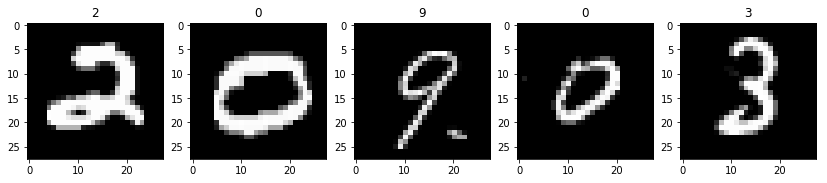

In [33]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [34]:
with open('submit04_v07.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))